### Generalized Latent Linear Growth Model (GLLGM)

The Generalized Latent Linear Growth Model (GLLGM) is a longitudinal model that captures unobservable linear trajectories over time.  At its core, it employs latent variables to model both the intercept and slope of these trajectories, and these trajectories are related to observed responses, which in turn enable their identification.

The GLLVM framework defines the following observation (condiional on the latent variables) model:

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known *link function*, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the *linear predictor*,  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. 

The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order, which we now discuss.


#### 1. Latent Variables:

For individual $i$, the random intercepts $\beta_{i0}$ and random slopes $\beta_{i1}$ are defined as:

$$
\beta_{i0} = 
\begin{pmatrix}
\beta_{i01}\\
\beta_{i02}
\end{pmatrix}
$$

$$
\beta_{i1} = 
\begin{pmatrix}
\beta_{i11}\\
\beta_{i12}
\end{pmatrix}
$$


For individual $i$ at time $t$, the trajectory of the latent outcome $z_{it}$ is modeled as:

$$ 
z_{it} = \beta_{i0} + \beta_{i1}(t-t_0) + \epsilon_{it}\\
\epsilon_{it} = A_\epsilon\epsilon_{it-1} + A_\delta\delta_{it}\\
\delta_{it} \sim N(0,I)\\
\epsilon_{i1} = \delta_{i1}
$$

We assume $\delta_it$ to be independent of $\beta_{i0}$ and $\beta_{i1}$ and for all $\delta_{i't'}$ such that $(i',t') \neq (i,t)$.
- $t_0$ is a reference time point 
- $A_\epsilon$ is a symmetric full $2 \times 2$ matrix with spectral norm $||A||_2 < 1$.
- $A_\delta$ is a diagonal $2 \times 2$.
- $(t - t_0)$ adjusts the trajectory based on deviation from the reference time.

The trajectory is thus modeled as a vector autoregressive process of order 1 around a linear trend. The residuals $\epsilon_{it}$ are not observable but $z_{it}$ affects the responses through the observation model.

Finally, the random intercepts and slope are  and parameters are defined according to

$$
\begin{pmatrix}
\beta_{i0}\\
\beta_{i1}
\end{pmatrix}
\sim 
MVN\left(
   \begin{pmatrix}
      \bm 0\\
      \bm \mu_{\beta_1}
   \end{pmatrix},
   \bm\Sigma
\right)
$$
with the full symmetric variance-covariance matrix $\bm \Sigma$ 

$$
\bm\Sigma = 
\begin{pmatrix}
\sigma_{01,01}&&&\\
&\sigma_{02,02}&&\\
&&\sigma_{11,11}&\\
&&&\sigma_{12,12}
\end{pmatrix}
\begin{pmatrix}
1&.&.&.\\
\rho_{02, 01}&1&.&.\\
\rho_{11, 01}&\rho_{11, 02}&1&.\\
\rho_{12, 01}&\rho_{12, 02}&\rho_{12, 11}&1\\
\end{pmatrix}
\begin{pmatrix}
1&&&\\
&1&&\\
&&\sigma_{11,11}&\\
&&&\sigma_{12,12}
\end{pmatrix}
$$

The matrix of standard deviation is diagonal and the matrix of correlation is a full, symmetric matrix. The standard deviation of the intercepts is fixed at one to identify the loadings of the model: $\sigma_{01,01} = \sigma_{02,02} = 1$. With this assumption the model reduces to a classical GLLVM if $T=1$.

## Implementation details
* The correlations need to be between 0 and 1
* The standard deviations must be nonnegative
* In the decoder we use the reparametrization trick and start the sampling from $\delta_{it}$ directy, and learn the parameters  $\mu$ and $L$, $\beta$ and $\lambda$ with backprop. 
* In the encoder we compute $z_{it}$ in a first step for all $t$ (same encoder for all $t$, using the assumed conditional independence across time given $z_{it}$), and then learn $\beta_{it}$. Finally, we use the transormation $\phi_{it} = L^{-1}(\beta_{it} - \mu)$ with $L$ and $\mu$ treated as fixed, so that we can estimate $\phi_{it}$ directly in the loss function.

# Todo

In [255]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# generate L
def gen_L(size):
    # Generate random matrix
    mat = torch.randn(size, size)
    
    # Zero out the upper triangle
    L = torch.tril(mat)
    
    # Ensure diagonal elements are positive
    L_diag = torch.diag(L).abs() + 1e-6  # adding a small constant for safety
    L = torch.tril(L, -1) + torch.diag(L_diag)
    
    return L

# generate (random_intercepts, random_slope) pairs from L
def gen_xi(n, mu, L):
    # Draw N(0, I)
    xi = torch.randn((n, L.shape[0])) # I need to estimate this with the encoder!
    # Transform to get N(mu, Sigma)
    xi = mu + xi @ L.T

    return(xi)

# generate the Z
def gen_z(xi, T= torch.linspace(0, 1, 10)):
    """
    Args:
        T: a Tensor of time points 
    """
    # Generate the intercepts
    intercepts = torch.stack([xi[:,0]] * T.shape[0], 1)
    # Add the slopes
    slopes = torch.stack([T - T[0]] * xi.shape[0], 0) * xi[:,1].unsqueeze(1)
    # Generate z

    z = intercepts + slopes
    z = z.unsqueeze(2)

    return(z)


def gen_x(n, k, T):
    x = torch.stack([torch.randn((n,k))] * T.shape[0], dim=1)
    return (x)

# Plot z
def plot_trajectories(z, number=10, T=None):
    """
    Plots the specified number of trajectories from z.
    
    Args:
    - z (torch.Tensor): The tensor containing trajectories. Each row is a trajectory.
    - number (int): The number of trajectories to plot.
    - T (torch.Tensor or None): Time points corresponding to the trajectories. 
                               If None, a range based on z's shape is used.
    """
    z = z.squeeze()
    if T is None:
        T = torch.arange(z.shape[1])
    
    if number > z.shape[0]:
        print(f"Warning: Requested {number} trajectories, but only {z.shape[0]} available.")
        number = z.shape[0]

    for i in range(number):
        plt.plot(T.numpy(), z[i].numpy(), label=f"Line {i+1}")

    plt.legend()
    plt.title(f"First {number} Trajectories in z")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()



In [256]:
class GLLGM(nn.Module):
    def __init__(self, p, q, k, T, response_types):
        super(GLLGM, self).__init__()  # Fixed this line

        # Initialize the covariance matrix
        # Assuming gen_L is defined somewhere else in your code
        self.B = nn.Parameter(torch.randn((p, k)))
        self.A = nn.Parameter(torch.randn((p, q)))
        self.mu = nn.Parameter(torch.randn((2*q))) # mean of intercepts and slopes
        self.L = nn.Parameter(gen_L(2*q)) # this is the "transformed" L that decomposes Sigma in LL'. The diagonal elements are the log of the true values.
        self.scale  = nn.Parameter(torch.rand((p))) # scale  parameter
        # Create a lower triangular mask
        self.mask = torch.tril(torch.ones(2*q, 2*q))

        self.settings = {
            "p": p, # number of responses
            "q": q, # number of latent 
            "T": T, # list time steps
            'response_types': response_types,
            'response_link': 
                {
                'gaussian': lambda x: x,
                'binary' : lambda x: torch.logit(x),
                'poisson': lambda x: torch.log(x),
                },
            'response_linkinv':
                {
                'gaussian': lambda x: x,
                'binary': lambda x: 1/(1+torch.exp(-x)),
                'poisson': lambda x: torch.exp(x)
                },
            'response_transform':
                {
                'gaussian': lambda x: x,
                'binary' : lambda x: 2*x - 1,
                'poisson': lambda x: torch.log(x+1)
                }
        }

    def sample(self, n, x, xi=None):
        if xi is None:
            xi = gen_xi(n, self.mu, self.L)
        
        _, mean, z = self(xi, x)
        Y = self.gen_Y(mean)
        return {'Y':Y, 'xi':xi, 'z':z, 'condmean': mean}
        
    def gen_Y(self, mean):
        Y = torch.zeros_like(mean)
        for response, id in self.settings['response_types'].items():
            if response == "gaussian":
                Y[:,:,id] = torch.poisson(mean[:,:,id])
            elif response == "poisson":
                Y[:,:,id] = mean[:,:,id] + torch.randn_like(mean[:,:,id]) * self.scale[id].unsqueeze(0)
        return(Y)


    def transform(self, eta=None, mu=None):
        if eta is not None and mu is not None:
            raise ValueError("Only eta or mu can be given.")
        
        if eta is not None:
            mu = torch.zeros_like(eta)
            # We transform eta to mu using the inverse link
            for response, id in self.settings['response_types'].items():
                mu[:,:,id] = self.settings['response_linkinv'][response](eta[:,:,id])
            return(mu)
        
        if mu is not None:
            eta = torch.zeros_like(mu)
            # We transform to eta using the link
            for response, id in self.settings['response_types'].items():
                eta[:,:,id] = self.settings['response_link'][response](mu[:,:,id])
            return(eta)
        

    def forward(self, xi, x):
        # Apply the mask to prevent gradient flowing to the zero part of the lower-triangular matrix
        L = self.L * self.mask
        # Take the exponential of the diagonal elements in-place
        torch.diagonal(L)[:] = torch.exp(torch.diagonal(L))
        # gen Z if z is none
        # gen Y
        # gen xi if xi is none (would be 0 of size of z)

        z = gen_z(xi, self.settings['T'])
        
        eta = x @ self.B.T + z @ self.A.T

        mean = self.transform(eta=eta)
        return(eta, mean, z)  # You probably want to return the transformed L


In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_features, num_hidden, num_out):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_out)
        )
        self.optimizer = torch.optim.Adam(l=0.001)

    def forward(self, y, xi_mu, xi_L):
        z = self.fc(y)
        L_inv = torch.inverse(xi_L)
        xi = (z - xi_mu) @ L_inv.T
        return(xi, z)
    
    def train(self, y, xi):
        z = self(y)




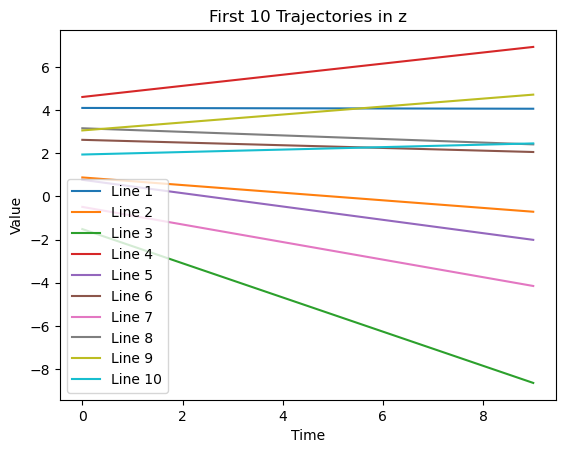

In [260]:
n = 1000
p = 10
q = 1
k = 0
T = torch.linspace(0, 1, 10)
x = gen_x(n, k, T)

response_types = {
    "poisson": np.arange(p)
}

model = GLLGM(p, q, k, T, response_types)

sample = model.sample(n, x)
# L = gen_L(2)
# print(L)

# torch.diagonal(L)[:] = torch.exp(torch.diagonal(L))
# print(L)

# xi = gen_xi(10000, torch.zeros((1,2)), L=L)
# z = gen_z(xi)

plot_trajectories(sample['z'].detach())
